## Task 1.1: (Image-based) Modal Mask -> Amodal Mask 
- (Image-based) Modal Mask-> Amodal Mask “Given an image of the modal mask of an object, predict the amodal mask of the same object” Inputs:- RGB Frame- 3-channel image (3, 256, 256)- Modal Mask of Object i- Binary (1-channel) image (1, 256, 256) Outputs:- Amodal Mask of Object i- Binary (1-channel) image (1, 256, 256)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import ToPILImage, ToTensor
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.io import write_video
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
import numpy as np
import random
import json
from IPython.display import Video

tensor_to_image = ToPILImage()
image_to_tensor = ToTensor()

## Model Definition

In [3]:
class SimpleConv2DModel(nn.Module):
    def __init__(self):
        super(SimpleConv2DModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),   # 256x256
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1),  # Output: (1, 256, 256)
        )

    def forward(self, rgb_image, modal_mask):
        x = torch.cat([rgb_image, modal_mask], dim=1)  # (B, 4, 256, 256)
        x = self.encoder(x)
        x = self.decoder(x)
        x = torch.sigmoid(x)  # For binary mask output
        return x

## Train/Test Data
- Basic Dataset: DummyAmodalDataset
- More Relevant Object Dataset: CIFAR10AmodalDataset
- Most Relevant Object Dataset: VOCdevkit

In [4]:
class DummyAmodalDataset(Dataset):
    def __init__(self, num_samples=100):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        rgb = np.random.rand(3, 256, 256).astype(np.float32)
        modal = np.random.randint(0, 2, (1, 256, 256)).astype(np.float32)
        amodal = np.random.randint(0, 2, (1, 256, 256)).astype(np.float32)
        return torch.tensor(rgb), torch.tensor(modal), torch.tensor(amodal)

# Create DataLoader
train_dataset = DummyAmodalDataset(num_samples=20)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [5]:
class CIFAR10AmodalDataset(Dataset):
    def __init__(self, num_samples=100):
        self.cifar = torchvision.datasets.CIFAR10(
            root='./test_data', train=True, download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((256, 256))
            ])
        )
        self.num_samples = min(num_samples, len(self.cifar))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        rgb, label = self.cifar[idx]
        modal = torch.zeros(1, 256, 256)
        amodal = torch.zeros(1, 256, 256)
        center_x, center_y = np.random.randint(64, 192, size=2)
        radius = np.random.randint(32, 64)
        Y, X = np.ogrid[:256, :256]
        dist_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
        modal[0][dist_from_center < radius] = 1.0
        amodal[0][dist_from_center < (radius + 10)] = 1.0
        return rgb, modal, amodal

# Create DataLoader
cifar_dataset = CIFAR10AmodalDataset(num_samples=20)
cifar_loader = DataLoader(cifar_dataset, batch_size=2, shuffle=True)

In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor()
])

voc_dataset = torchvision.datasets.VOCSegmentation(
    root='./test_data',
    year='2012',
    image_set='train',
    download=True,
    transform=transform,
    target_transform=target_transform
)

voc_loader = DataLoader(voc_dataset, batch_size=2, shuffle=True)

In [7]:
train_loader = cifar_loader

## Training Function

In [10]:
def train_model(model, dataloader, num_epochs=3, lr=1e-3, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for rgb_image, modal_mask, amodal_mask in dataloader:
            rgb_image = rgb_image.to(device)
            modal_mask = modal_mask.to(device)
            amodal_mask = amodal_mask.to(device)

            optimizer.zero_grad()
            output = model(rgb_image, modal_mask)
            loss = criterion(output, amodal_mask)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

In [12]:
# Instantiate and train
model1 = SimpleConv2DModel()
train_model(model1, train_loader, num_epochs=3)

Epoch 1/3, Loss: 0.6712
Epoch 2/3, Loss: 0.3965
Epoch 3/3, Loss: 0.2604


In [116]:
# Hyperparameter tuning
model1 = SimpleConv2DModel()
train_model(model1, train_loader, num_epochs=10)

Epoch 1/10, Loss: 0.6766
Epoch 2/10, Loss: 0.5155
Epoch 3/10, Loss: 0.2091
Epoch 4/10, Loss: 0.1735
Epoch 5/10, Loss: 0.1468
Epoch 6/10, Loss: 0.1218
Epoch 7/10, Loss: 0.1230
Epoch 8/10, Loss: 0.1234
Epoch 9/10, Loss: 0.1123
Epoch 10/10, Loss: 0.1154


In [38]:
# Hyperparameter tuning
model = SimpleConv2DModel()
train_model(model, train_loader, num_epochs=50)

Epoch 1/50, Loss: 0.7123
Epoch 2/50, Loss: 0.4161
Epoch 3/50, Loss: 0.2230
Epoch 4/50, Loss: 0.1482
Epoch 5/50, Loss: 0.1339
Epoch 6/50, Loss: 0.1317
Epoch 7/50, Loss: 0.1612
Epoch 8/50, Loss: 0.1501
Epoch 9/50, Loss: 0.1319
Epoch 10/50, Loss: 0.1274
Epoch 11/50, Loss: 0.1199
Epoch 12/50, Loss: 0.1169
Epoch 13/50, Loss: 0.1105
Epoch 14/50, Loss: 0.1123
Epoch 15/50, Loss: 0.1080
Epoch 16/50, Loss: 0.1054
Epoch 17/50, Loss: 0.1058
Epoch 18/50, Loss: 0.1005
Epoch 19/50, Loss: 0.1002
Epoch 20/50, Loss: 0.1002
Epoch 21/50, Loss: 0.0951
Epoch 22/50, Loss: 0.1020
Epoch 23/50, Loss: 0.0950
Epoch 24/50, Loss: 0.0947
Epoch 25/50, Loss: 0.0938
Epoch 26/50, Loss: 0.0913
Epoch 27/50, Loss: 0.0896
Epoch 28/50, Loss: 0.0934
Epoch 29/50, Loss: 0.0989
Epoch 30/50, Loss: 0.0943
Epoch 31/50, Loss: 0.0862
Epoch 32/50, Loss: 0.0890
Epoch 33/50, Loss: 0.0928
Epoch 34/50, Loss: 0.0897
Epoch 35/50, Loss: 0.0920
Epoch 36/50, Loss: 0.0880
Epoch 37/50, Loss: 0.0864
Epoch 38/50, Loss: 0.0945
Epoch 39/50, Loss: 0.

## Prediction Visualizations

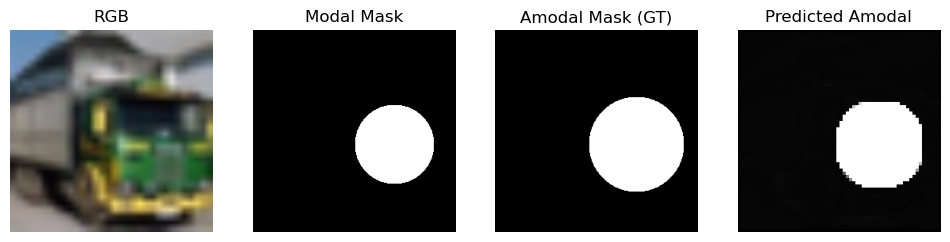

In [71]:
rgb_image, modal_mask, amodal_mask = next(iter(train_loader))
model.eval()
with torch.no_grad():
    pred_amodal = model(rgb_image, modal_mask)

plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
plt.imshow(rgb_image[0].permute(1,2,0).numpy())
plt.title("RGB")
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(modal_mask[0,0].numpy(), cmap='gray')
plt.title("Modal Mask")
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(amodal_mask[0,0].numpy(), cmap='gray')
plt.title("Amodal Mask (GT)")
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(pred_amodal[0,0].numpy(), cmap='gray')
plt.title("Predicted Amodal")
plt.axis('off')
plt.show()

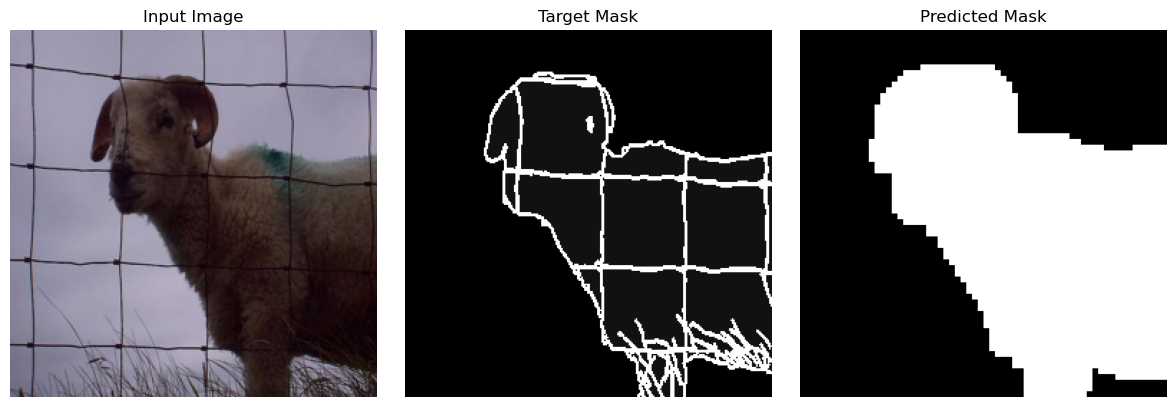

In [141]:
input_batch, target_batch = next(iter(voc_loader))
model1.eval()  

with torch.no_grad():
    preds = model1(input_batch, target_batch)  
    if preds.shape[1] > 1:
        rounded_preds = torch.argmax(preds, dim=1, keepdim=True)
    else:
        rounded_preds = (preds > 0.5).float()

fig, axes = plt.subplots(1, 3, figsize=(12,4))

axes[0].imshow(tensor_to_image(input_batch[0]))
axes[0].set_title("Input Image")
axes[0].axis('off')

axes[1].imshow(tensor_to_image(target_batch[0]), cmap='gray')
axes[1].set_title("Target Mask")
axes[1].axis('off')

axes[2].imshow(tensor_to_image(rounded_preds[0]), cmap='gray')
axes[2].set_title("Predicted Mask")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [142]:
rounded_preds.shape, target_batch.shape

(torch.Size([2, 1, 256, 256]), torch.Size([2, 1, 256, 256]))

In [143]:
rounded_preds.shape, target_batch.unsqueeze(1).shape

(torch.Size([2, 1, 256, 256]), torch.Size([2, 1, 1, 256, 256]))

In [144]:
is_same = (rounded_preds == target_batch.unsqueeze(1))
is_same

tensor([[[[[ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           ...,
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True]]],


         [[[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False]]]],



        [[[[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, F

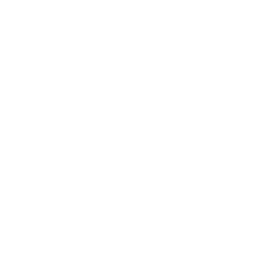

In [145]:
is_same = (rounded_preds == target_batch.unsqueeze(1))
img_tensor = is_same[0].float().squeeze()  
img = tensor_to_image(img_tensor)
img

In [146]:
print('Total Correct:', is_same.sum())
print('Total Amount:', is_same.numel())
print('Overall Accuracy:', is_same.sum() / is_same.numel())

Total Correct: tensor(34144)
Total Amount: 262144
Overall Accuracy: tensor(0.1302)


### Task 1.2: (Image-based) Modal Content (RGB)-> Amodal Content (RGB) 
- “Given an image of the modal RGB content of an object, predict the amodal RGB content of the same object” “Can use the amodal masks of that object” 
- Inputs:- RGB Frame- 3-channel image (3, 256, 256)- Amodal Mask of Object i- Binary (1channel) image (1, 256, 256)- RGB Content of Object i- 3-channel image (3, 256, 256)- Use the object’s modal mask to “crop out” the RGB content of object i- Optional to use? Outputs:- Amodal RGB Content of Object i- 3-channel image (3, 256, 256)

### Use the provided data instead of test data